In [1]:
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
import Lasso.lasso_model as Lasso
import PCR.PCR_model as PCR
import Random_Forrest.rf_model as RF
import XGBoost.xgboost_model as XGBoost

# Inflation Forecasting

This notebook investigates how four different models perform in forecasting inflation. The analysis is designed to reflect a realistic decision-making context, as faced by an economist or policy advisor.

---

## Structure of the Notebook

### 1. **Data and Preprocessing**
- Import and preparation of the dataset.
- Target variable: Inflation.
- Explanatory variables: A range of macroeconomic indicators.

### 2. **Rolling Forecast Evaluation (Multi-Horizon)**
- For each point in time, the models forecast inflation *h* months ahead, where *h = 1, ..., 12*.
- The following models are evaluated:
  - LASSO
  - Principal Component Regression (PCR)
  - Random Forest
  - XGBoost
- Model performance is assessed using MAE and RMSE across forecast horizons.
- This section provides a general comparison of predictive accuracy over time.

### 3. **12-Month Ahead Forecast Case (Historical Simulation)**
- Each model is trained on data up to the end of 2021 and used to forecast inflation throughout 2022.
- The forecast is compared to actual realized inflation as well as to the Danish central bank’s published inflation expectations for 2022.
- This historical simulation illustrates how the models would have performed in a real-world policy setting and provides a benchmark for their practical relevance.

---

## Objective of the Analysis

The goal is twofold:
1. To evaluate the overall predictive performance of different forecasting models across time and horizons, and  
2. To demonstrate how these models can be applied in a practical setting to support economic decision-making.

By combining technical evaluation with applied forecasting, the analysis provides a balanced foundation for model assessment and recommendation.

# 1. Data and Preprocessing

In [5]:
# Navigate to data folder
os.chdir('Data')

# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 268)


In [6]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 267)


# Functions

In [41]:
def run_all_forecasters(X, y, forecast_horizon, last_observation_date, scaler, trees, window_length=108, verbose=True):
    """
    Run LASSO, XGBoost, PCR, and Random Forest forecasters and combine their forecasts in one DataFrame.

    Args:
        X: DataFrame of predictors
        y: Series of the target variable
        forecast_horizon: int, number of steps ahead to forecast
        last_observation_date: str or pd.Timestamp, origin date for forecasting
        scaler: fitted sklearn scaler
        trees: int, number of trees for Random Forest
        window_length: int, size of the rolling window (default: 108 months)
        verbose: bool, whether to print model details
    Returns:
        pd.DataFrame with forecasts from all models
    """

    # --- Run LASSO ---
    lasso_df = Lasso.lasso_forecast(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    
    lasso_df.rename(columns={"Inflation forecast": "LASSO"}, inplace=True)

        
    # --- Run XGBoost ---
    xgb_df = XGBoost.XGBoost_Forecaster(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    xgb_df.rename(columns={"Inflation forecast": "XGBoost"}, inplace=True)

    # --- Run PCR ---
    pcr_df = PCR.pcr_forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        variance_threshold=0.95,
        window_length=window_length,
        verbose=verbose
    )
    pcr_df.rename(columns={"Inflation forecast": "PCR"}, inplace=True)

    # --- Run Random Forest ---
    rf_df = RF.RandomForest_Forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        trees=trees,
        window_length=window_length,
        verbose=verbose
    )
    rf_df.rename(columns={"Inflation forecast": "RandomForest"}, inplace=True)

    # --- Merge all forecasts on Date and Horizon ---
    combined_df_old = lasso_df[["Date", "Horizon", "LASSO"]] \
        .merge(xgb_df[["Date", "XGBoost"]], on="Date") \
        .merge(pcr_df[["Date", "PCR"]], on="Date") \
        .merge(rf_df[["Date", "RandomForest"]], on="Date")
    
    combined_df = lasso_df[["Date", "Horizon", "LASSO"]] \
    .merge(xgb_df[["Date", "Horizon", "XGBoost"]], on=["Date", "Horizon"]) \
    .merge(pcr_df[["Date", "Horizon", "PCR"]], on=["Date", "Horizon"]) \
    .merge(rf_df[["Date", "Horizon", "RandomForest"]], on=["Date", "Horizon"])


    return combined_df

def evaluate_window_lengths(X, y, window_lengths, forecast_horizon, last_observation_date, scaler, trees):
    results = []

    for w in window_lengths:
        print(f"\n--- Testing window_length={w} ---")
        try:
            forecast_df = run_all_forecasters(
                X=X,
                y=y,
                forecast_horizon=forecast_horizon,
                last_observation_date=last_observation_date,
                scaler=scaler,
                trees=trees,
                window_length=w,
                verbose=False
            )

            benchmark_df = forecast_df.merge(y.reset_index(), on="Date", how="left")
            mae_scores = {
                model: mean_absolute_error(benchmark_df["Inflation"], benchmark_df[model])
                for model in ["LASSO", "XGBoost", "PCR", "RandomForest"]
            }

            mae_scores["window_length"] = w
            results.append(mae_scores)

        except Exception as e:
            print(f"Window length {w} failed: {e}")

    return pd.DataFrame(results)

def run_all_forecasters_and_evaluate(X, y, forecast_horizon, start_date, end_date, window_length=108, trees=100):
    """
    Run forecasts from all models and return both forecast dataframe and evaluation (MAE/RMSE per horizon).
    """
    all_model_forecasts = []

    model_funcs = {
        "LASSO": Lasso.run_rolling_forecast,
        "XGBoost": XGBoost.run_rolling_forecast,
        "PCR": PCR.run_rolling_forecast,
        "RandomForest": RF.run_rolling_forecast,
    }

    for model_name, func in model_funcs.items():
        print(model_name)
        df = func(
            X=X, y=y,
            forecast_horizon=forecast_horizon,
            start_date=start_date,
            end_date=end_date,
            window_length=window_length
        )
        df["Model"] = model_name
        all_model_forecasts.append(df)

    forecasts_df = pd.concat(all_model_forecasts, ignore_index=True)
    #forecasts_df = forecasts_df.rename(columns={"Inflation forecast": "Forecast", "Date": "Dato"})
    #forecasts_df = forecasts_df[["Date", "Horizon", "Forecast_made_in", "Model", "Forecast"]]
    
    forecasts_df = forecasts_df.rename(columns={"Inflation forecast": "Forecast"})
    forecasts_df = forecasts_df[["Date", "Horizon", "Forecast_made_in", "Model", "Forecast"]]

    # forecasts_df, evaluation_df
    return forecasts_df

def evaluate_all_models(forecasts_df, y, metric="RMSE"):
    """
    Evaluates forecasts from each model and returns a wide-format DataFrame:
    rows = Horizon, columns = model names, values = selected metric (e.g., RMSE or MAE).

    Args:
        forecasts_df (pd.DataFrame): Output from `run_all_forecasters(...)`
        y (pd.Series): True target values
        metric (str): Evaluation metric to return in wide format ("RMSE", "MAE")

    Returns:
        pd.DataFrame: Wide-format evaluation matrix
    """

    evaluation_all = []

    for model in forecasts_df["Model"].unique():
        model_df = forecasts_df[forecasts_df["Model"] == model].copy()
        model_df = model_df.rename(columns={"Forecast": "Inflation forecast"})
        eval_df, _ = Lasso.evaluate_forecasts(model_df, y)
        eval_df["Model"] = model
        evaluation_all.append(eval_df)

    # Combine all evaluations
    evaluation_df = pd.concat(evaluation_all, ignore_index=True)

    # Pivot to wide format: one row per Horizon, one column per model
    wide_eval = evaluation_df.pivot_table(
        index="Horizon",
        columns="Model",
        values=metric
    ).reset_index()

    return wide_eval

# 2. **Training Window Selection (Grid Search)**

Before performing rolling forecasts, we evaluate how the length of the training window affects forecast accuracy.  
Using a simple grid search over different window lengths (e.g., 60, 84, 96, 108, 120 months), we estimate 1-month-ahead forecasts across a validation period and compare performance.

The objective is to select the window length that provides the best balance between bias and variance — large enough to capture macroeconomic patterns, but short enough to adapt to structural shifts.

The selected optimal window length is then used throughout the remaining forecasting exercises.

In [14]:
%%time
window_lengths_to_test = [12, 24, 36, 60, 84, 96, 108, 120, 132]
results_df = evaluate_window_lengths(
    X=X,
    y=y,
    window_lengths=window_lengths_to_test,
    forecast_horizon=12,
    last_observation_date="2021-12-01",
    scaler=scaler,
    trees=250
)


--- Testing window_length=30 ---

--- Testing window_length=60 ---

--- Testing window_length=84 ---

--- Testing window_length=96 ---

--- Testing window_length=108 ---

--- Testing window_length=120 ---

--- Testing window_length=132 ---
Window length 132 failed: Not enough data for the chosen rolling window length.
CPU times: user 5min 3s, sys: 7min 11s, total: 12min 14s
Wall time: 2min 46s


In [15]:
results_df

,LASSO,XGBoost,PCR,RandomForest,window_length
0,5.391033,4.857734,5.235919,5.115627,30
1,5.939423,5.137676,5.325125,5.378221,60
2,5.740461,5.073348,5.319836,5.168223,84
3,5.502260,5.048931,5.321966,5.159900,96
4,5.564720,5.092504,5.265604,5.100399,108
5,5.836408,5.278201,5.286534,5.456159,120


From this table, we observe that:
- **XGBoost consistently outperforms the other models**, achieving the lowest MAE in most window settings.
- PCR shows relatively stable performance across window lengths, suggesting that the model is less sensitive to training sample size than LASSO or Random Forest.
- The optimal window length for most models lies between **84 and 96 months**, after which performance either plateaus or worsens.
- LASSO shows more variability and appears to degrade with longer windows.

These findings highlight the importance of choosing an appropriate window size, especially for regularized or tree-based models in a rolling forecasting setup.


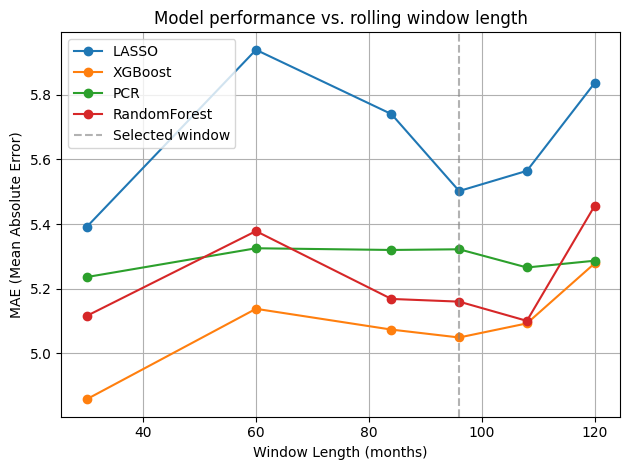

In [51]:
# Plot each model's MAE across window lengths
for model in ["LASSO", "XGBoost", "PCR", "RandomForest"]:
    plt.plot(results_df["window_length"], results_df[model], marker='o', label=model)

plt.title("Model performance vs. rolling window length")
plt.xlabel("Window Length (months)")
plt.ylabel("MAE (Mean Absolute Error)")
plt.axvline(96, color='grey', linestyle='--', alpha=0.6, label="Selected window")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**We select 96 months as the preferred training window, as it offers a stable performance across models and avoids the degradation seen with longer windows.**

# 4. Rolling Forecast Evaluation (Multi-Horizon)

With the training window length now selected, we evaluate the performance of each model in a realistic real-time forecasting setting.

Following the procedure in Garcia et al. (2017), we implement a multi-horizon rolling forecast framework. At each point in time (from January 2023 to December 2024), each model is re-estimated using the most recent 96 months of data and used to generate forecasts \( h = 1, .. , 12 \) months ahead.

This approach mimics the constraints faced by practitioners: models are trained only on data available up to that point and updated sequentially over time. Performance is then evaluated out-of-sample using RMSE (and optionally MAE) at each horizon.

> Note: The function `run_all_forecasters_and_evaluate()` is computationally intensive and takes several minutes to execute.  
This is because each model is re-trained multiple times — once for every evaluation date — across all forecast horizons.  
Especially tree-based methods like Random Forest are time-consuming due to their repeated fitting and internal optimization steps.



In [21]:
%%time
forecasts_df = run_all_forecasters_and_evaluate(
    X=X, 
    y=y, 
    forecast_horizon=12, 
    start_date="2023-01-01",
    end_date="2024-12-01",
    window_length=96
)

LASSO
XGBoost
PCR
RandomForest
CPU times: user 8min 32s, sys: 9min 13s, total: 17min 46s
Wall time: 4min 56s


#### Forecast Accuracy by Model and Horizon

The following tables show RMSE and MAE for each model across forecast horizons \( h = 1, .., 12 \).

In [22]:
rmse_matrix = evaluate_all_models(forecasts_df, y, metric="RMSE")
rmse_matrix

Model,Horizon,LASSO,PCR,RandomForest,XGBoost
0,0,0.861937,0.918319,1.048681,0.840273
1,1,1.733872,1.854109,1.892060,1.714068
2,2,1.807174,2.218310,2.174131,1.742258
3,3,1.747541,2.633371,2.579208,2.387389
4,4,2.470404,2.825236,3.567436,2.968300
5,5,2.151958,2.750917,3.508731,3.104753
6,6,2.372205,3.204840,3.543749,3.289648
7,7,2.696319,3.850371,4.176222,3.812052
8,8,3.229659,4.121213,4.247467,4.424563
9,9,3.570139,3.954545,4.097917,4.602184


In [23]:
mae_matrix = evaluate_all_models(forecasts_df, y, metric="MAE")
mae_matrix

Model,Horizon,LASSO,PCR,RandomForest,XGBoost
0,0,0.645913,0.713765,0.732415,0.618543
1,1,1.333690,1.376629,1.430076,1.300855
2,2,1.409441,1.656370,1.678666,1.343038
3,3,1.443005,1.991014,2.169087,1.950817
4,4,2.025901,2.068366,3.166392,2.454808
5,5,1.488241,1.854495,2.991898,2.434757
6,6,1.767338,2.195905,2.629728,2.380652
7,7,1.838903,2.691364,3.026756,2.680666
8,8,2.166967,2.730912,3.215721,3.410150
9,9,2.455367,2.569686,3.054578,3.501190


Across both RMSE and MAE, XGBoost and LASSO generally outperform Random Forest and PCR, especially at shorter horizons.

- **XGBoost** shows the lowest error at short horizons (e.g., \( h = 1 \)), and maintains relatively stable performance up to \( h = 6 \).
- **LASSO** performs competitively throughout, especially when strong regularization reduces overfitting at longer horizons.
- **Random Forest** and **PCR** show higher errors, particularly beyond 6 months, likely due to overfitting (in RF) or lack of adaptation (in PCR).

This confirms that model choice matters more at longer horizons, and that regularized or boosting-based methods may be better suited for inflation forecasting under structural change.


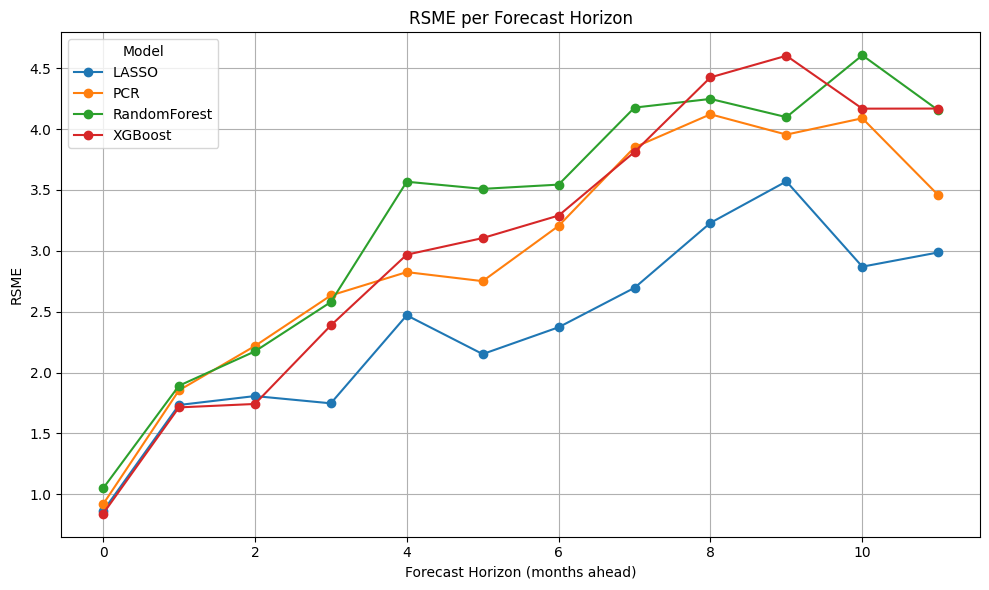

In [24]:
plt.figure(figsize=(10, 6))

for model in rmse_matrix.columns[1:]:  # Skip 'Horizon' column
    plt.plot(
        rmse_matrix["Horizon"],
        rmse_matrix[model],
        marker="o",
        label=model
        )

plt.title(f"RSME per Forecast Horizon")
plt.xlabel("Forecast Horizon (months ahead)")
plt.ylabel("RSME")
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()

As expected, forecast accuracy declines with increasing horizon length.  
XGBoost and LASSO generally achieve lower RMSE values, particularly at shorter horizons.  
Random Forest and PCR perform relatively worse, with higher errors at longer horizons, possibly due to overfitting (RF) or insufficient flexibility (PCR).

This comparison highlights the importance of model selection when forecasting inflation beyond the short term.

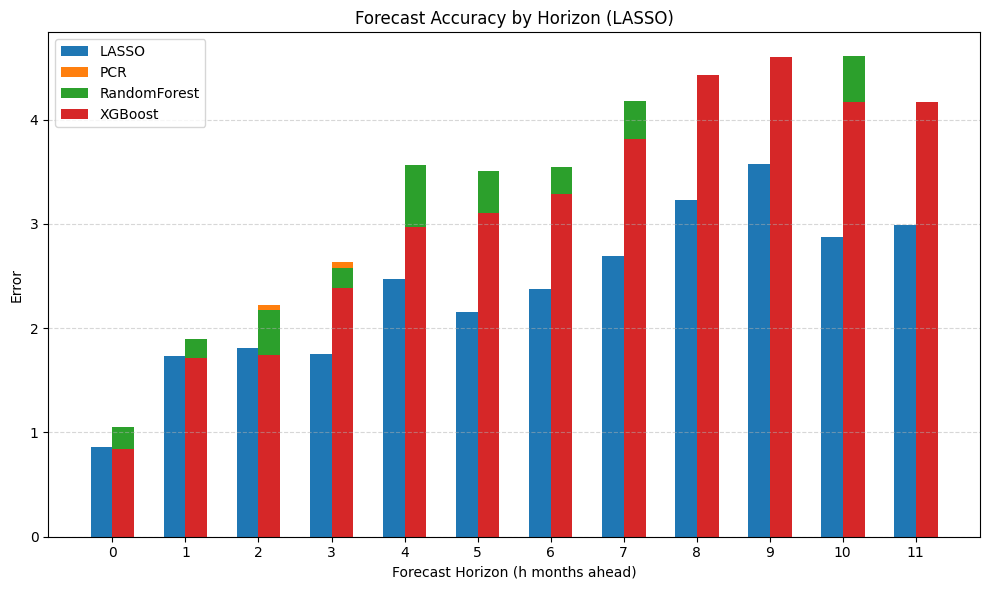

In [103]:
# Smid første kolonne 'Model' og gør long-format
plt.figure(figsize=(10, 6))
h = rmse_matrix["Horizon"]

# Plot MAE og RMSE som søjler
bar_width = 0.3
plt.bar(h - bar_width/2, rmse_matrix["LASSO"], width=bar_width, label="LASSO")
plt.bar(h + bar_width/2, rmse_matrix["PCR"], width=bar_width, label="PCR")
plt.bar(h + bar_width/2, rmse_matrix["RandomForest"], width=bar_width, label="RandomForest")
plt.bar(h + bar_width/2, rmse_matrix["XGBoost"], width=bar_width, label="XGBoost")


plt.xlabel("Forecast Horizon (h months ahead)")
plt.ylabel("Error")
plt.title("Forecast Accuracy by Horizon (LASSO)")
plt.xticks(h)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 12-Month Ahead Forecast Case (Historical Simulation)

In [26]:
forecast_results = run_all_forecasters(
    X=X,
    y=y,
    forecast_horizon=12,
    last_observation_date="2021-12-01",
    scaler=scaler,
    trees=200,
    window_length=96,
    verbose=None
)

In [27]:
benchmark_df = forecast_results.merge(y.reset_index(), on='Date', how="left")
benchmark_df

,Date,Horizon,LASSO,XGBoost,PCR,RandomForest,Inflation
0,2022-01-01,0,3.051650,3.094929,2.932095,2.920145,4.344
1,2022-02-01,1,2.627879,2.886632,2.421737,2.673525,4.798
2,2022-03-01,2,1.317671,2.707271,2.503847,2.647555,5.369
3,2022-04-01,3,1.384224,2.720335,2.646912,2.490950,6.686
4,2022-05-01,4,1.950454,2.866160,2.461925,2.359880,7.436
5,2022-06-01,5,1.469289,2.237402,2.300497,2.439145,8.190
6,2022-07-01,6,3.874978,2.519572,2.080133,2.353030,8.704
7,2022-08-01,7,2.728954,2.205071,2.113287,2.438810,8.910
8,2022-09-01,8,1.906305,2.157745,2.303889,2.402015,10.019
9,2022-10-01,9,2.782161,2.710652,2.420692,2.471700,10.112


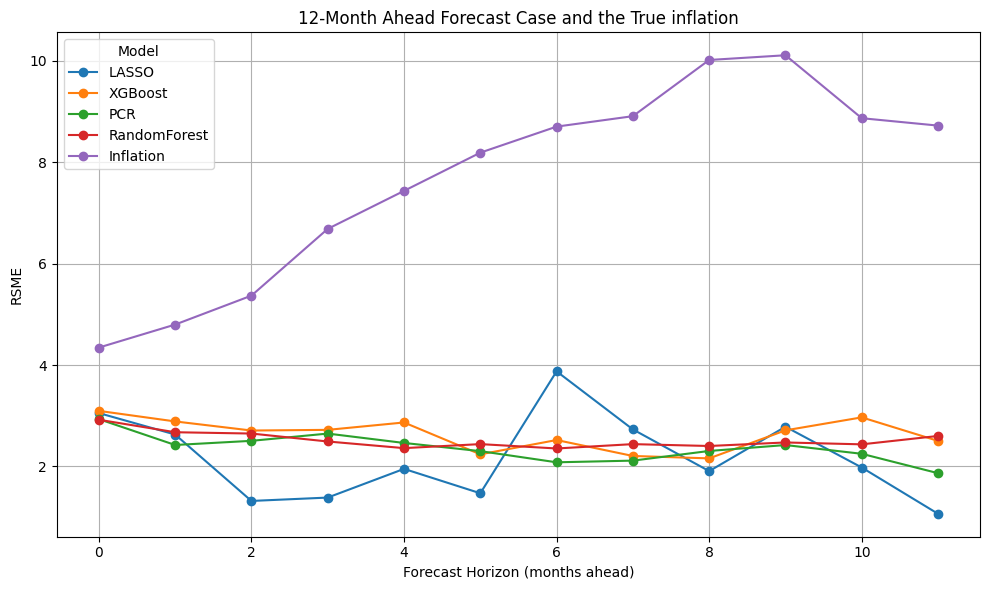

In [28]:
plt.figure(figsize=(10, 6))

for i in benchmark_df.columns[2:]:  # Skip 'Date' & 'Horizon' column
    plt.plot(
        benchmark_df["Horizon"],
        benchmark_df[i],
        marker="o",
        label=i
        )

plt.title(f"12-Month Ahead Forecast Case and the True inflation")
plt.xlabel("Forecast Horizon (months ahead)")
plt.ylabel("RSME")
plt.legend(title="Model")
plt.grid(True)
plt.tight_layout()
plt.show()